### 75.06/95.58 Organización de Datos: Trabajo Práctico 1 ###
#### Primer Cuatrimestre de 2020 ####



In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

tweets = pd.read_csv('train.csv') 
tweets.tail()

,id,keyword,location,text,target
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1
7612,10873,NaN,NaN,The Latest: More Homes Razed by Northern Calif...,1


In [2]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [3]:
tweets['text'].describe()

count                                                  7613
unique                                                 7503
top       11-Year-Old Boy Charged With Manslaughter of T...
freq                                                     10
Name: text, dtype: object

In [4]:
tweets['location'].describe()

count     5080
unique    3341
top        USA
freq       104
Name: location, dtype: object

In [5]:
tweets['keyword'].describe()

count           7552
unique           221
top       fatalities
freq              45
Name: keyword, dtype: object

In [6]:
duplicados = tweets.duplicated(subset = 'text', keep = False)
duplicados.value_counts()

False    7434
True      179
dtype: int64

In [7]:
tweets.drop_duplicates(subset = 'text', keep = False, inplace = True)
tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7434 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7434 non-null   int64 
 1   keyword   7378 non-null   object
 2   location  4982 non-null   object
 3   text      7434 non-null   object
 4   target    7434 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 348.5+ KB


TOP 50 DESASTRES COMENTADOS EN LOS TWEETS

In [8]:
desastres = tweets.groupby("keyword").agg({"target":["count","mean"]}).copy()
level0 = desastres.columns.get_level_values(0)
level1 = desastres.columns.get_level_values(1)
desastres.columns = level0 + "_" + level1
desastres.sort_values(by="target_count",ascending = False,inplace = True)
desastres = desastres.head(50) #TOP 50

[]

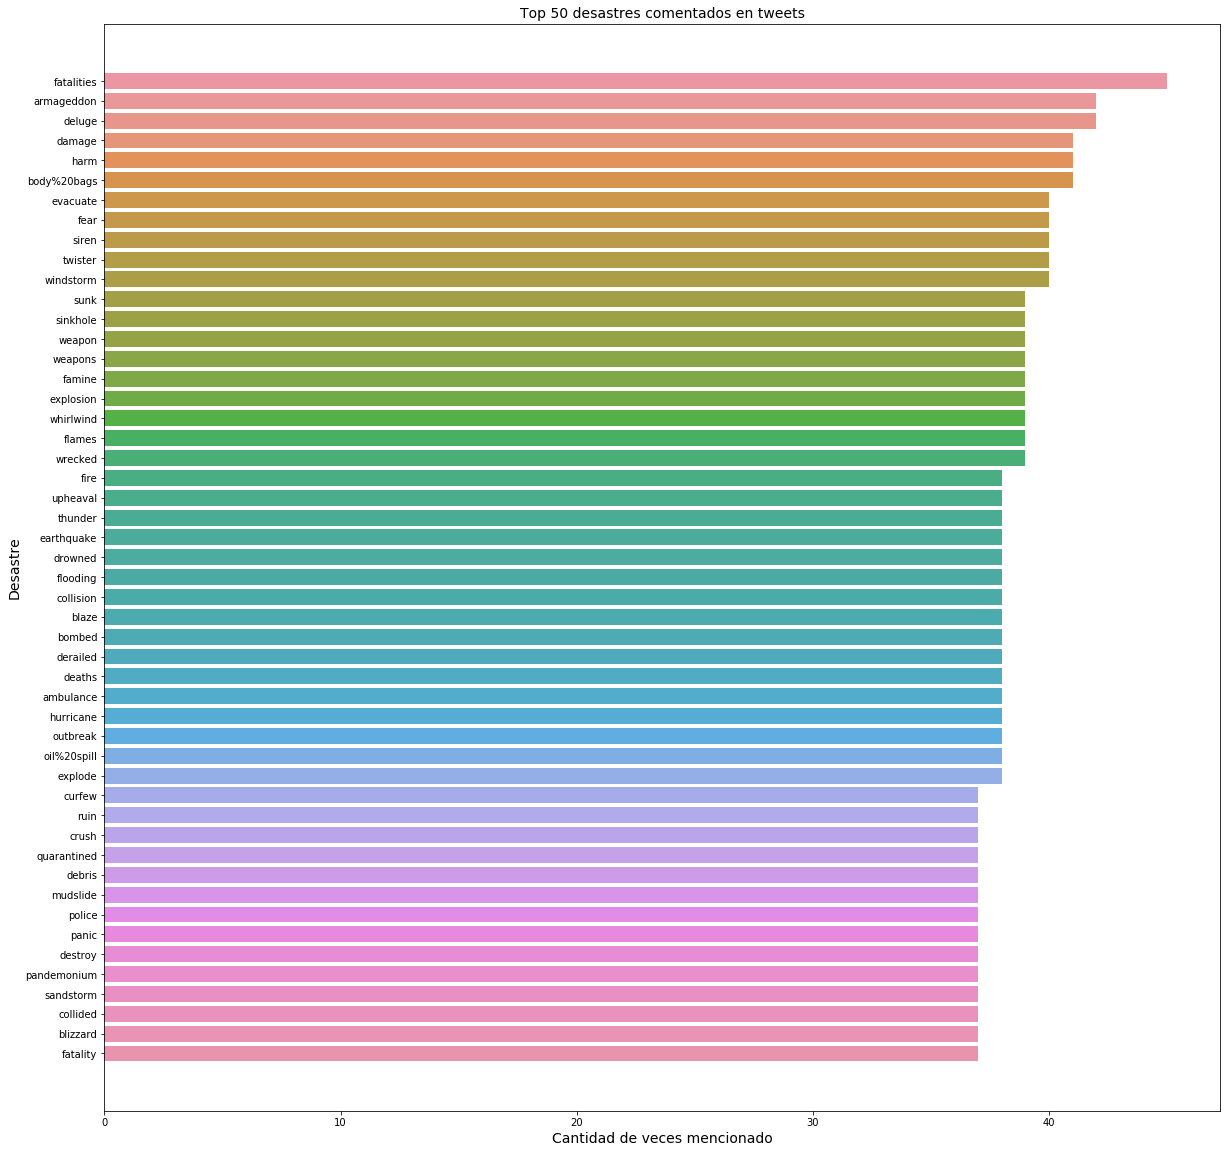

In [9]:
fig = plt.figure(figsize=(20,20))
grafico = sns.barplot(data = desastres,x = "target_count",y = desastres.index)
grafico.set_title("Top 50 desastres comentados en tweets",fontsize = 14)
grafico.set_xlabel("Cantidad de veces mencionado",fontsize = 14)
grafico.set_ylabel("Desastre",fontsize = 14)
grafico.plot()

### Análisis por longitud de tweet.

In [15]:
tweets_length = tweets[['text','target']]

tweets_length.count()

text      7434
target    7434
dtype: int64

In [16]:
tweets_length['text'].hasnans

False

In [17]:
tweets_length['length'] = tweets_length['text'].str.len()
tweets_length.head()

,text,target,length
0,Our Deeds are the Reason of this #earthquake M...,1,69
1,Forest fire near La Ronge Sask. Canada,1,38
2,All residents asked to 'shelter in place' are ...,1,133
3,"13,000 people receive #wildfires evacuation or...",1,65
4,Just got sent this photo from Ruby #Alaska as ...,1,88


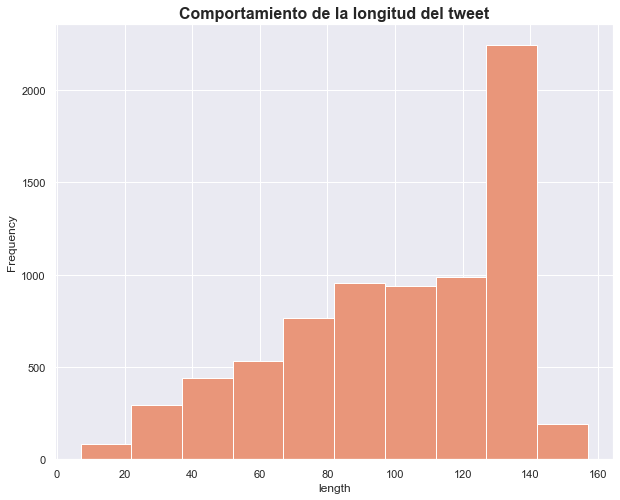

In [39]:
fig=plt.figure()
ax = fig.add_subplot(111)

plt.title('Comportamiento de la longitud del tweet',fontsize=16,fontweight='bold')
ax.set_xlabel('length')
tweets_length['length'].plot.hist(color='darksalmon', figsize=(10, 8))

plt.show()

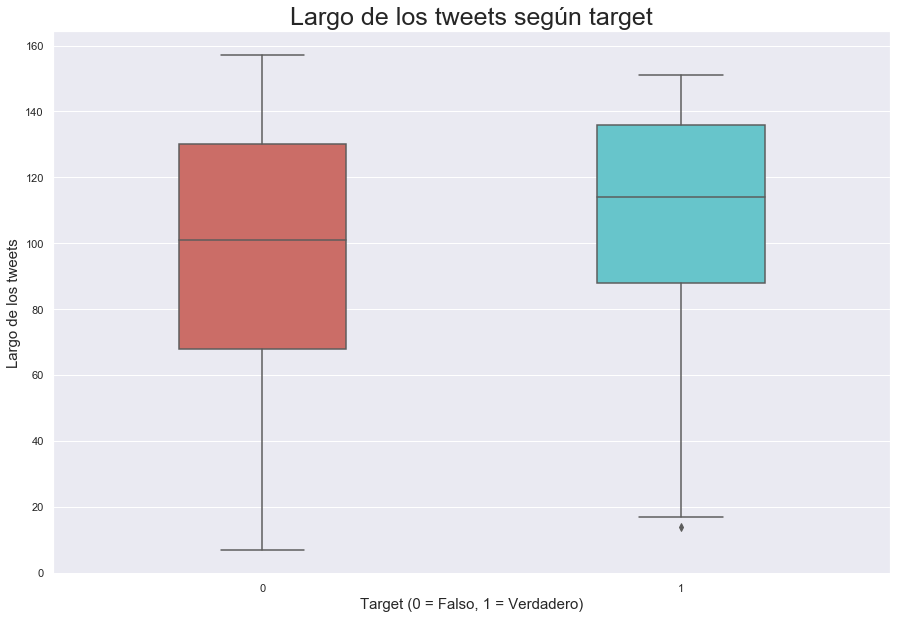

In [33]:
g = sns.boxplot(x = 'target', y = 'length', data = tweets_length, palette = 'hls', width = 0.4)
g.set_title("Largo de los tweets según target", fontsize = 25)
g.set_xlabel("Target (0 = Falso, 1 = Verdadero)", fontsize = 15)
g.set_ylabel("Largo de los tweets", fontsize = 15)
sns.set(rc = {'figure.figsize' : (15,10)})

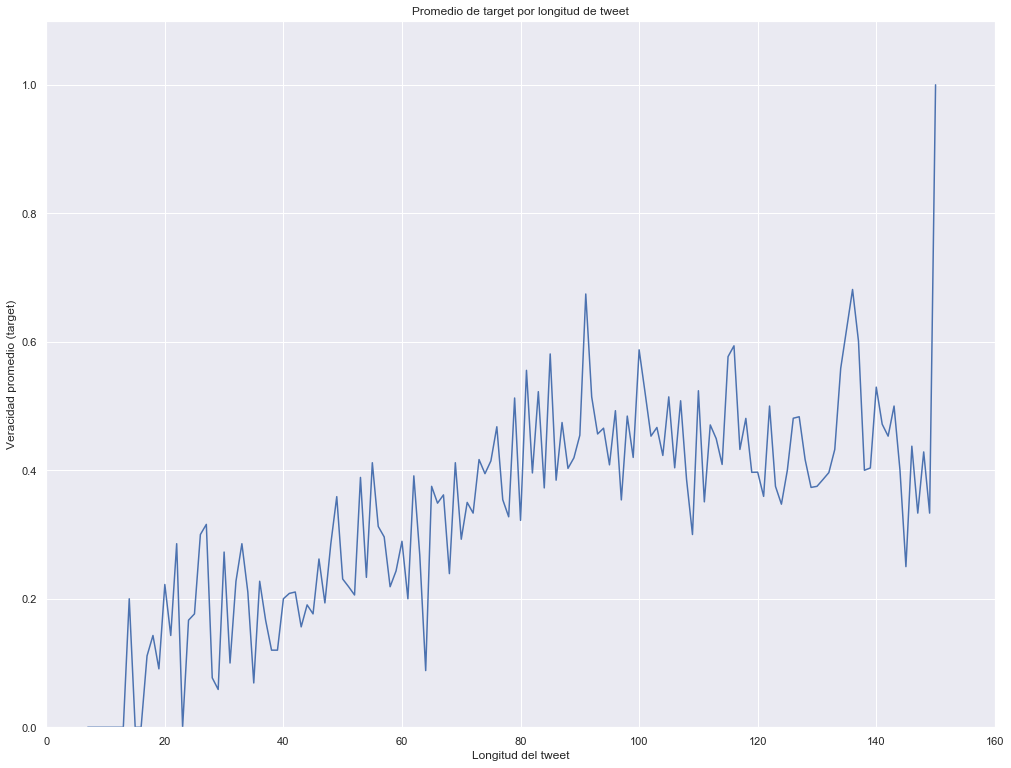

In [36]:
grouped = tweets_length.groupby('length')['target'].agg(['mean','count'])

grouped[(grouped['count'] >= 2)]['mean'].plot(kind = "line",figsize = (17,13))
plt.title('Promedio de target por longitud de tweet')
plt.xlabel('Longitud del tweet')
plt.ylabel('Veracidad promedio (target)')
plt.xlim(0,160)
plt.ylim(0,1.1)
plt.show()

In [29]:
tweets_length['avg_length'] = tweets_length.groupby('target')['length'].transform('mean')
tweets_length.head()

,text,target,length,avg_length
0,Our Deeds are the Reason of this #earthquake M...,1,69,108.095238
1,Forest fire near La Ronge Sask. Canada,1,38,108.095238
2,All residents asked to 'shelter in place' are ...,1,133,108.095238
3,"13,000 people receive #wildfires evacuation or...",1,65,108.095238
4,Just got sent this photo from Ruby #Alaska as ...,1,88,108.095238


In [41]:
tweets_length['is_above_avg_length'] = tweets_length['length'] > tweets_length['avg_length']
tweets_length.head()

,text,target,length,avg_length,is_above_avg_length
0,Our Deeds are the Reason of this #earthquake M...,1,69,108.095238,False
1,Forest fire near La Ronge Sask. Canada,1,38,108.095238,False
2,All residents asked to 'shelter in place' are ...,1,133,108.095238,True
3,"13,000 people receive #wildfires evacuation or...",1,65,108.095238,False
4,Just got sent this photo from Ruby #Alaska as ...,1,88,108.095238,False


In [55]:
groupedby_is_above_avg_length = tweets_length.groupby('is_above_avg_length').agg({'target':['mean','count']})
groupedby_is_above_avg_length

target      
                         mean count
is_above_avg_length                
False                0.419517  3392
True                 0.427264  4042

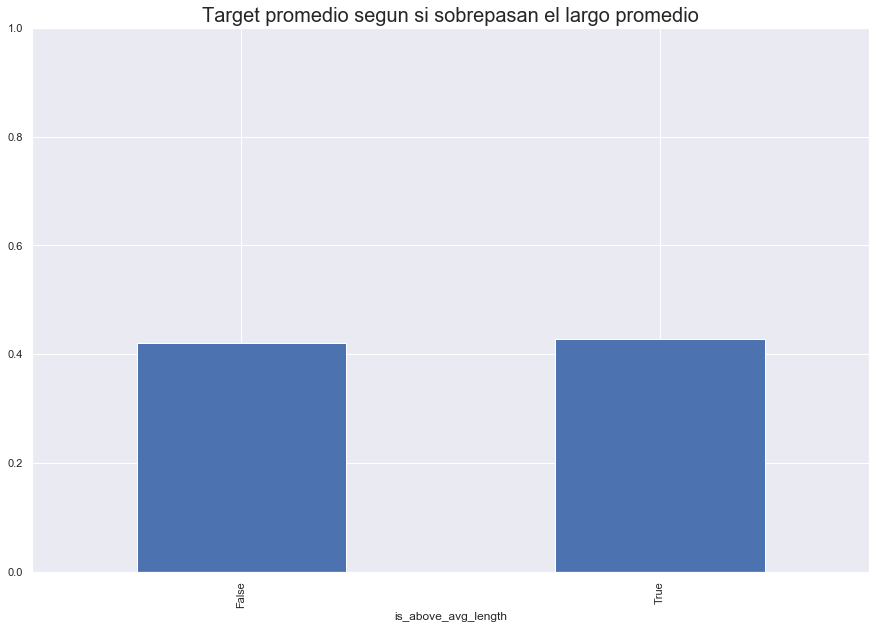

In [64]:
groupedby_is_above_avg_length[('target','mean')].plot(kind = 'bar', figsize = (15,10))
plt.title('Target promedio segun si sobrepasan el largo promedio', fontsize = 20)
plt.ylim(0,1)
plt.show()

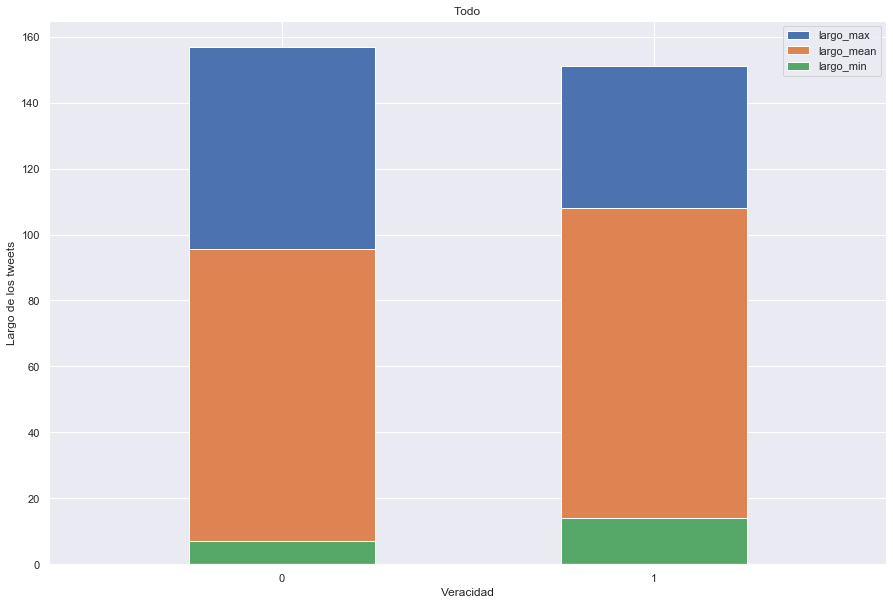

In [82]:
#grafico de promedio de longitud por target
visualizacion = tweets_length.groupby('target').agg({'length':['mean','max','min']})

c = visualizacion.columns.get_level_values(0)
v = visualizacion.columns.get_level_values(1)
visualizacion.columns = c + '_' + v
visualizacion.reset_index()


fig, ax = plt.subplots(figsize = (15,10))
ax.bar(visualizacion.index, visualizacion['length_max'],0.5, label='largo_max')
ax.bar(visualizacion.index, visualizacion['length_mean'],0.5, label='largo_mean')

ax.bar(visualizacion.index, visualizacion['length_min'],0.5, label='largo_min')

plt.margins(x=0.25)
plt.xticks([0,1])
ax.set_xlabel('Veracidad')
ax.set_ylabel('Largo de los tweets')
ax.set_title('Todo')
ax.legend()

plt.show()

In [104]:
# generamos una columna para agregar y procesar mediante una tabla pivot


tweets_length['is_a_tweet'] = 1
for_heatmap = tweets_length.pivot_table(index = 'length', columns = 'target', values = 'is_a_tweet', aggfunc = 'sum')
for_heatmap

target,0,1
length,,
7,3.0,NaN
8,4.0,NaN
9,2.0,NaN
10,2.0,NaN
11,4.0,NaN
...,...,...
150,NaN,2.0
151,NaN,1.0
152,1.0,NaN


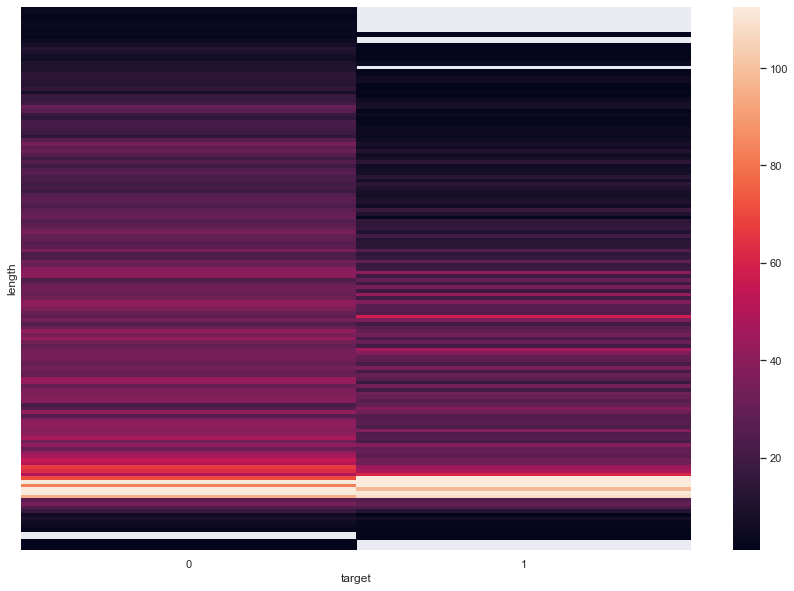

In [108]:
g = sns.heatmap(for_heatmap, robust = True, yticklabels = False)#, cmap="YlGnBu")#, square = True)#, linewidths=1)

In [111]:
tweets_to_corr = tweets_length[['length','target']]
tweets_to_corr.corr(method = 'pearson')

,length,target
length,1.000000,0.181208
target,0.181208,1.000000


In [164]:

tweets_to_corr = tweets_length[['length','target','is_above_avg_length']]
#tweets_to_corr['mean'] = tweets_length['length'].mean()
tweets_to_corr['avg_target_by_length'] = tweets_length.groupby('length')['target'].transform('mean')
tweets_to_corr.head(20)
tweets_to_corr.corr(method = 'spearman')

,length,target,is_above_avg_length,avg_target_by_length
length,1.000000,0.162665,0.852293,0.561074
target,0.162665,1.000000,0.007809,0.261479
is_above_avg_length,0.852293,0.007809,1.000000,0.404196
avg_target_by_length,0.561074,0.261479,0.404196,1.000000


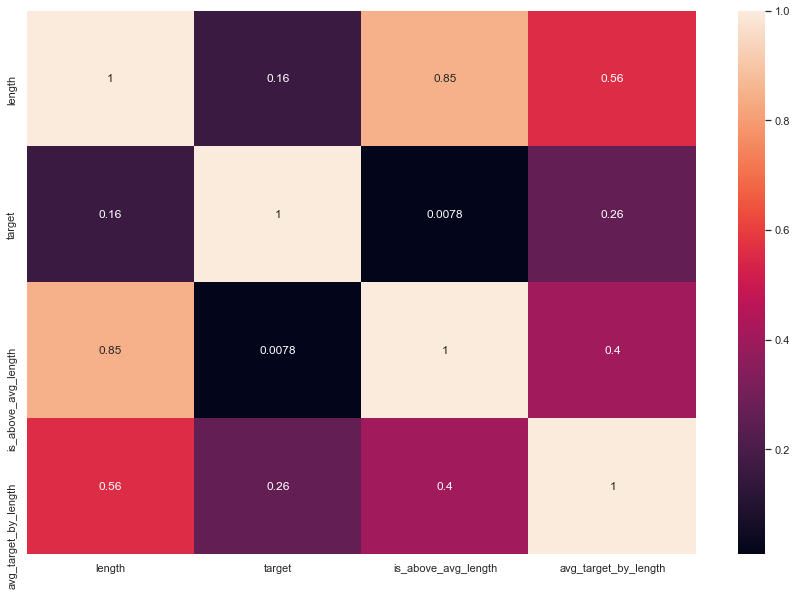

In [167]:
sns.heatmap(tweets_to_corr.corr(method = 'spearman'), annot = True)

## Bueno hasta todo lo relacionado a longitud

## Ahora vamos con relacion links en tweet vs veracidad
Si contienen links ver su target

In [169]:
tweets_content = tweets[['text','target']]
tweets_content

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...
7604,#WorldNews Fallen powerlines on G:link tram: U...,1
7605,on the flip side I'm at Walmart and there is a...,1
7606,Suicide bomber kills 15 in Saudi security site...,1
7608,Two giant cranes holding a bridge collapse int...,1


In [188]:
tweets_by_http = tweets_content[tweets_content.text.str.contains('http://')]
tweets_by_https = tweets_content[tweets_content.text.str.contains('https://')]
tweets_by_links = tweets_by_http.append(tweets_by_https)
tweets_by_links

,text,target
31,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1
32,We always try to bring the heavy. #metal #RT h...,0
33,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1
35,On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0
37,INEC Office in Abia Set Ablaze - http://t.co/3...,1
...,...,...
7474,I'm a friggin wreck destiel sucks (read the vi...,0
7480,Ranking #artectura #pop2015 #Nå¼36 Florence + ...,0
7535,Wreckage 'conclusively confirmed' as from MH37...,1
7552,Israel wrecked my home. Now it wants my land. ...,1


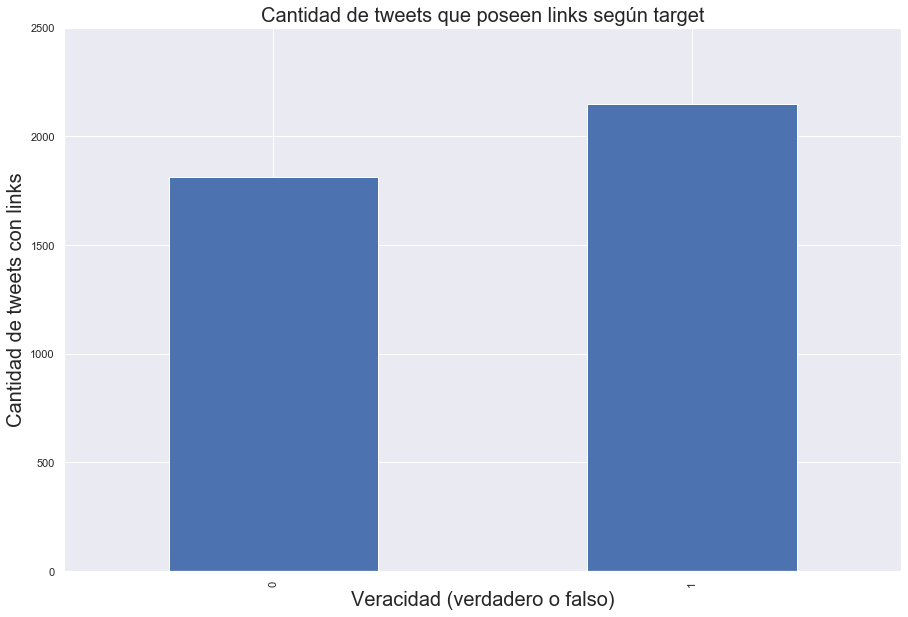

In [225]:
tweets_by_links.groupby('target')['text'].count().plot(kind = 'bar', figsize = (15,10))
plt.title('Cantidad de tweets que poseen links según target', fontsize = 20)
plt.xlabel('Veracidad (verdadero o falso)', fontsize = 20)
plt.ylabel('Cantidad de tweets con links', fontsize = 20)
plt.ylim(0,2500)
plt.show()

In [206]:
tweets_by_links['length'] = tweets_length['length'].copy()
tweets_by_links

,text,target,length
31,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1,55
32,We always try to bring the heavy. #metal #RT h...,0,67
33,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1,82
35,On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0,76
37,INEC Office in Abia Set Ablaze - http://t.co/3...,1,55
...,...,...,...
7474,I'm a friggin wreck destiel sucks (read the vi...,0,86
7480,Ranking #artectura #pop2015 #Nå¼36 Florence + ...,0,124
7535,Wreckage 'conclusively confirmed' as from MH37...,1,109
7552,Israel wrecked my home. Now it wants my land. ...,1,71


In [212]:
#Pispeo los valores
tweets_by_links.groupby('target').agg({'length':['count', 'mean']})

length            
        count        mean
target                   
0        1811  108.310878
1        2148  111.778399

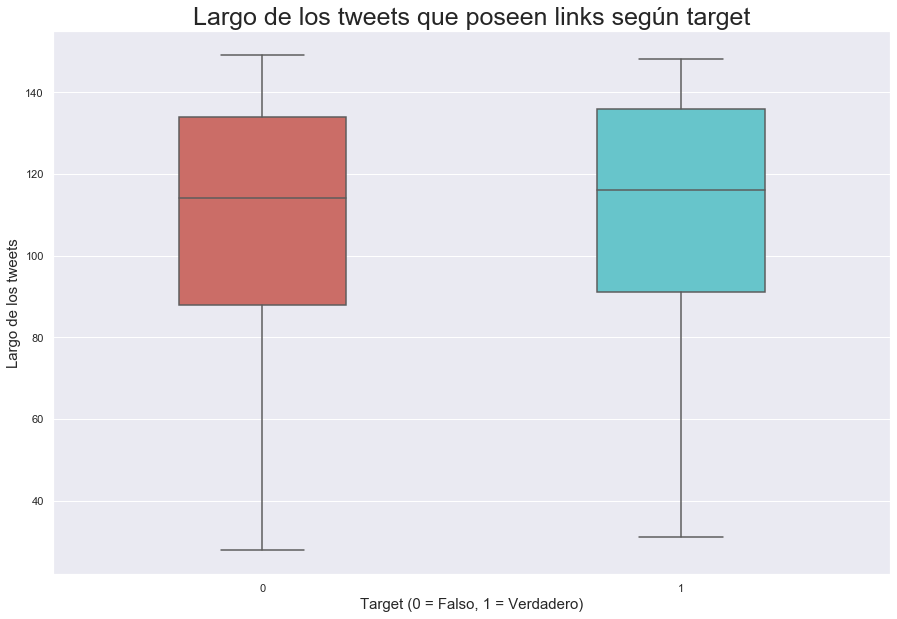

In [214]:
g = sns.boxplot(x = 'target', y = 'length', data = tweets_by_links, palette = 'hls', width = 0.4)
g.set_title("Largo de los tweets que poseen links según target", fontsize = 25)
g.set_xlabel("Target (0 = Falso, 1 = Verdadero)", fontsize = 15)
g.set_ylabel("Largo de los tweets", fontsize = 15)
sns.set(rc = {'figure.figsize' : (15,10)})

Faltaría ver específico separando por http y https una especie de métrica para ver si lo que usan el mas seguro suelen ser mas reales (eg. links oficiales)